In [1]:
import numpy as np
import re
import subprocess
import matplotlib.pyplot as plt
import matplotlib 
import astropy.units as u
from astropy.io import fits
from astropy.constants import m_p, M_sun

import os
gd_folder = os.getcwd()+"/../../Calculations/SKIRTOR/"

import sys 
sys.path.append(gd_folder)
#from loadSKIRTOR_MRN77 import LoadSKIRTOR_MRN77
from loadSKIRTOR_MRN77_force_reg import LoadSKIRTOR_MRN77
from loadSKIRTOR_General import LoadSKIRTOR_General

sys.path.append("../utility_functions/")
from objectProperties import ObjectProperties
from readExtrapolatedSpectra import ReadExtrapolatedSpectra

sys.path.append("../../Filter_Curves/")
from readBands import ReadBands

In [2]:
#Use the latex font when plotting. 
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [3]:
wid = "W0204-0506"

In [4]:
#Load the properties of the BHDs
op = ObjectProperties([wid])

In [5]:
#Load the bands.
bands = ReadBands()
for bname in bands.bandnames:
    print(bname, bands.bp[bname].barlam(), bands.bp[bname].fwhm(), bands.bp[bname].rectwidth())

R_SPECIAL 6501.229535920617 Angstrom 1159.881393925198 Angstrom 1624.9974574790472 Angstrom
I_BESS 7925.773360798338 Angstrom 1080.5202412457434 Angstrom 1433.1539789444323 Angstrom
v_HIGH 5531.691038305597 Angstrom 850.6231300284223 Angstrom 1195.0838113345558 Angstrom


In [6]:
#Load the spectra for each BHD, extended using the best-fit SED.
specs = ReadExtrapolatedSpectra([wid])

Wavelength range for object W0019-1046 limited because of sky template
Spec-range: 3001.5 Angstrom - 5423.93 Angstrom
Sky-range: 3199.4 Angstrom - 6724.06 Angstrom
Wavelength range for object W0204-0506 limited because of sky template
Spec-range: 3786.2 Angstrom - 6672.70 Angstrom
Sky-range: 3789.3 Angstrom - 6682.76 Angstrom
Warning, 2 of 3161 bins contained negative fluxes; they have been set to zero.
Wavelength range for object W0831+0140 limited because of sky template
Spec-range: 3786.2 Angstrom - 6672.45 Angstrom
Sky-range: 3789.3 Angstrom - 6682.76 Angstrom
Warning, 2 of 3161 bins contained negative fluxes; they have been set to zero.


In [7]:
#Read the MRN77 chi2 map. 
p_map = dict()
chi2_map = dict()
pw = LoadSKIRTOR_MRN77()

bands_use = list()
p_meas = list()
p_unc = list()
for band in op.pfrac[wid].keys():
    bands_use.append(bands.bp[band])
    p_meas.append(op.pfrac[wid][band])
    p_unc.append(op.epfrac[wid][band])

fname = "maps/chi2_map_{}.fits".format(wid)
h = fits.open(fname)
tang_grid = np.array(h[0].header['TANGGRID'].split()).astype(float)
tang_grid = tang_grid * u.Unit(h[0].header['TANGUNIT'])
cang_grid = np.array(h[0].header['CANGGRID'].split()).astype(float)
cang_grid = cang_grid * u.Unit(h[0].header['CANGUNIT'])
iang_grid = np.array(h[0].header['IANGGRID'].split()).astype(float)
iang_grid = iang_grid * u.Unit(h[0].header['IANGUNIT'])
chi2_map[wid] = np.ma.zeros((len(tang_grid), len(cang_grid), len(iang_grid)))
chi2_map[wid][:,:,:] = h[0].data
chi2_map[wid].mask = h[1].data.astype(bool)
print(wid, chi2_map[wid][0,0,0])

W0204-0506 1406.8097571842277


In [8]:
#Find the best solution for W0204-0506
i, j, k = np.unravel_index(np.argmin(chi2_map[wid], axis=None), chi2_map[wid].shape)
print(tang_grid[i], cang_grid[j], iang_grid[k], chi2_map[wid].min())

48.0 deg 35.5 deg 75.5 deg 1.0702936615588873e-07


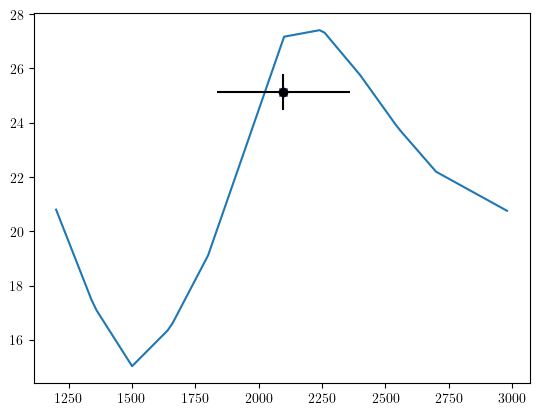

In [9]:
lam_grid = np.arange(1200., 3000., 20.)*u.AA
plt.plot(lam_grid, 100*pw.p((tang_grid[i]*np.ones(lam_grid.shape), cang_grid[j]*np.ones(lam_grid.shape), iang_grid[k]*np.ones(lam_grid.shape), lam_grid)))

for bname in op.pfrac[wid].keys():
    plt.errorbar([bands.bp[bname].barlam().value/(1+op.z[wid])], [op.pfrac[wid][bname]], xerr=[bands.bp[bname].rectwidth().value/2./(1+op.z[wid])], yerr=[op.epfrac[wid][bname]], marker='o', color='k')

    #p_mod = pw.p_bb(bands.bp[bname], [tang_grid[i]], [cang_grid[j]], [iang_grid[k]], specs.lam_obs[wid], specs.flam[wid], op.z[wid])
    #plt.plot([bands.bp[bname].barlam().value/(1+op.z[wid])], [p_mod[0,0,0]*100], 'bx')
    p_mod = pw.p_bb(bands.bp[bname], tang_grid[i:i+1], cang_grid[j:j+1], iang_grid[k:k+1], specs.lam_obs[wid], specs.flam[wid], op.z[wid])
    plt.plot([bands.bp[bname].barlam().value/(1+op.z[wid])], [p_mod[0,0,0]*100], 'bx')

In [33]:
#Set the additional SKIRTOR models we want to plot for W0204-0506
other_sk_models = [

    #Draine (2003) models
    {"d03_mod":"MW" , "ls":'dashdot', "label":"Draine (2003) Mixtures", "color":"xkcd:grey"},
    {"d03_mod":"LMC", "ls":'dashdot', "label":None, "color":"xkcd:grey"},
    {"d03_mod":"SMC", "ls":'dashdot', "label":None, "color":"xkcd:grey"},

    #MRN77_gra models
    {"gs_min":0.005, "gs_max":0.25, "a":0.0, "ls":"dashed", "label":None, "color":"blue"},
    {"gs_min":0.005, "gs_max":0.25, "a":2.0, "ls":"dashed", "label":None, "color":"blue"},
    {"gs_min":0.005, "gs_max":0.25, "a":3.5, "ls":"dashed", "label":r"$\rm MRN77_{\rm gra}$", "color":"blue"},

    #MRN77_gra+sil models
    {"gs_min":0.005, "gs_max":0.25, "a":3.5, "sil":True,"ls":"dashed", "label":r'$\rm MRN77_{\rm gra+\rm sil}$', "color":"magenta"},

    #Large grain models gra only
    {"gs_min":0.1, "gs_max":1, "a":0.0, "ls":"dotted", "label":r"0.1-1$\mu m$ Gra only", "color":"green"},
    {"gs_min":0.1, "gs_max":1, "a":0.5, "ls":"dotted", "label":None, "color":"green"},
    {"gs_min":0.1, "gs_max":1, "a":1.5, "ls":"dotted", "label":None, "color":"green"},
    {"gs_min":0.1, "gs_max":1, "a":2.5, "ls":"dotted", "label":None, "color":"green"},
    {"gs_min":0.1, "gs_max":1, "a":3.5, "ls":"dotted", "label":None, "color":"green"},

    #Large grain models with silicates.
    {"gs_min":0.1, "gs_max":1 , "a":3.5, "sil":True, "ls":"dotted", "label":r"0.1-1$\mu m$ Gra + Sil", "color":"red"},
    {"gs_min":1  , "gs_max":10, "a":3.5, "sil":True, "ls":"dotted", "label":r"1-10$\mu m$ Gra + Sil", "color":"tab:olive"},

    #Gaskell et al. (2004)
    {"gs_min":0.005, "gs_max":0.2 , "a":2.05, "ls":(0, (3, 5, 1, 5, 1, 5)), "label":r"Gaskell et al. (2004)$_{\rm gra}$", "color":"pink"},
    {"gs_min":0.005, "gs_max":0.2 , "a":2.05, "sil":True, "ls":(0, (3, 5, 1, 5, 1, 5)), "label":r"Gaskell et al. (2004)$_{\rm gra+\rm sil}$", "color":"cyan"},
]
other_sk = list()
other_chi2 = list()
for oskm in other_sk_models:
    oskm_obj_call = {k:v for k,v in oskm.items() if k not in ["ls","label","color"]}
    other_sk.append(LoadSKIRTOR_General(**oskm_obj_call))
    chi2_aux = np.zeros(len(iang_grid))
    for bname in op.pfrac[wid].keys():
        p_aux = other_sk[-1].p_bb(bands.bp[bname], iang_grid, specs.lam_obs[wid], specs.flam[wid], specs.specs.sp[wid].zspec)
        chi2_aux += ((p_aux*100 - op.pfrac[wid][bname])/op.epfrac[wid][bname])**2
    other_chi2.append(chi2_aux)


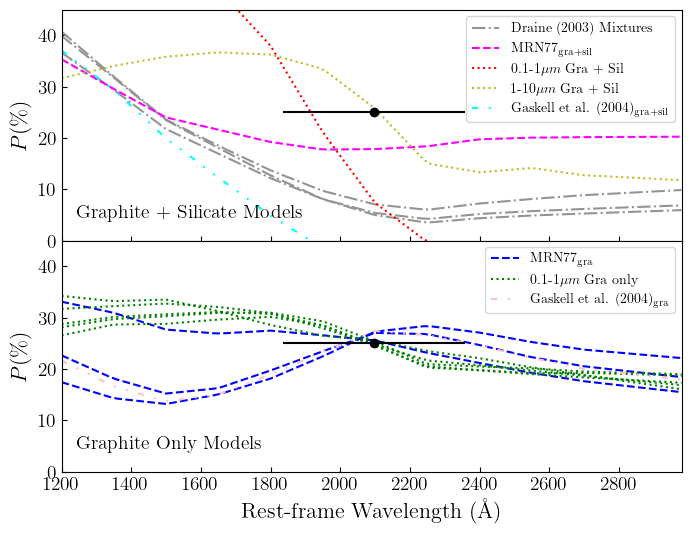

In [38]:
fig, axs = plt.subplots(2, sharex=True, sharey=True, figsize=(8,6))#, figsize=(10,4))
plt.subplots_adjust(wspace=0., hspace=0.)

for ax in axs:
    ax.tick_params(axis='both', which='both', direction='in', labelsize=14)

lam_grid = np.arange(1200., 3000., 20.)*u.AA

for mm, osk in enumerate(other_sk):
    oskm = other_sk_models[mm]
    kk = np.argmin(other_chi2[mm])
    if "d03_mod" in oskm or ("sil" in oskm and oskm["sil"]):
        ax = axs[0]
    else:
        ax = axs[1]
    ax.plot(lam_grid, 100*osk.p((iang_grid[kk]*np.ones(lam_grid.shape), lam_grid)), c=oskm["color"],ls=oskm["ls"], label=oskm["label"])

for bname in op.pfrac[wid].keys():
    for ax in axs:
        ax.errorbar([bands.bp[bname].barlam().value/(1+op.z[wid])], [op.pfrac[wid][bname]], xerr=[bands.bp[bname].rectwidth().value/2./(1+op.z[wid])], yerr=[op.epfrac[wid][bname]], marker='o', c='black', markeredgecolor='black')

min_curve = np.zeros(len(lam_grid)) + 1e32
max_curve = np.zeros(len(lam_grid))
for ind in np.argwhere(chi2_map[wid]<1.0):
    i1, j1, k1 = ind
    curve = 100*pw.p((tang_grid[i1]*np.ones(lam_grid.shape), cang_grid[j1]*np.ones(lam_grid.shape), iang_grid[k1]*np.ones(lam_grid.shape), lam_grid))
    min_curve = np.where(curve<min_curve, curve, min_curve)
    max_curve = np.where(curve>max_curve, curve, max_curve)
#ax.fill_between(lam_grid.value, min_curve, max_curve, color='xkcd:green', alpha=0.3, label=r'$\rm MRN77_{\rm gra}$')

for ax in axs:
    ax.legend()
    ax.set_ylim([0., 45.])
    ax.set_xlim([np.min(lam_grid.value), np.max(lam_grid.value)])
    ax.set_ylabel(r"$P (\%)$", fontsize=16)
axs[1].set_xlabel(r"Rest-frame Wavelength $(\rm \AA)$", fontsize=16)

axs[0].text(0.025, 0.1, "Graphite + Silicate Models", fontsize=14, transform=axs[0].transAxes)
axs[1].text(0.025, 0.1, "Graphite Only Models", fontsize=14, transform=axs[1].transAxes)

fig.savefig("SKIRTOR_W0204_all.png", dpi=200, bbox_inches='tight')


In [30]:
#Now, only do some selected models for the main Figure of the W0204-0506 paper. 
#Set the additional SKIRTOR models we want to plot for W0204-0506
other_sk_models = [

    #Draine (2003) models
    {"d03_mod":"MW" , "ls":'dotted', "label":"Draine (2003) Mixtures"},
    {"d03_mod":"LMC", "ls":'dotted', "label":None},
    {"d03_mod":"SMC", "ls":'dotted', "label":None},

    #MRN77_gra models
    # {"gs_min":0.005, "gs_max":0.25, "a":0.0, "ls":"dashed", "label":None},
    # {"gs_min":0.005, "gs_max":0.25, "a":2.0, "ls":"dashed", "label":None},
    # {"gs_min":0.005, "gs_max":0.25, "a":3.5, "ls":"dashed", "label":r"$\rm MRN77_{\rm gra}$"},

    #MRN77_gra+sil models
    {"gs_min":0.005, "gs_max":0.25, "a":3.5, "sil":True,"ls":"solid", "label":r'$\rm MRN77_{\rm gra+\rm sil}$'},

    #Large grain models gra only
    # {"gs_min":0.1, "gs_max":1, "a":0.0, "ls":"dotted", "label":"Large grains"},
    # {"gs_min":0.1, "gs_max":1, "a":0.5, "ls":"dotted", "label":"Large grains"},
    # {"gs_min":0.1, "gs_max":1, "a":1.5, "ls":"dotted", "label":"Large grains"},
    # {"gs_min":0.1, "gs_max":1, "a":2.5, "ls":"dotted", "label":"Large grains"},
    # {"gs_min":0.1, "gs_max":1, "a":3.5, "ls":"dotted", "label":"Large grains"},

    #Large grain models wit silicates.
    {"gs_min":0.1, "gs_max":1 , "a":3.5, "sil":True, "ls":"dashed", "label":None},
    {"gs_min":1  , "gs_max":10, "a":3.5, "sil":True, "ls":"dashed", "label":r"Large grains$_{\rm gra+\rm sil}$"},

    #Gaskell et al. (2004)
    #{"gs_min":0.005, "gs_max":0.2 , "a":2.05, "ls":(0, (3, 5, 1, 5, 1, 5)), "label":r"Gaskell et al. (2004)$_{\rm gra}$"},
    {"gs_min":0.005, "gs_max":0.2 , "a":2.05, "sil":True, "ls":"dashdot", "label":r"Gaskell et al. (2004)$_{\rm gra+\rm sil}$"},
    

]
other_sk = list()
other_chi2 = list()
for oskm in other_sk_models:
    oskm_obj_call = {k:v for k,v in oskm.items() if k not in ["ls","label"]}
    other_sk.append(LoadSKIRTOR_General(**oskm_obj_call))
    chi2_aux = np.zeros(len(iang_grid))
    for bname in op.pfrac[wid].keys():
        p_aux = other_sk[-1].p_bb(bands.bp[bname], iang_grid, specs.lam_obs[wid], specs.flam[wid], specs.specs.sp[wid].zspec)
        chi2_aux += ((p_aux*100 - op.pfrac[wid][bname])/op.epfrac[wid][bname])**2
    other_chi2.append(chi2_aux)


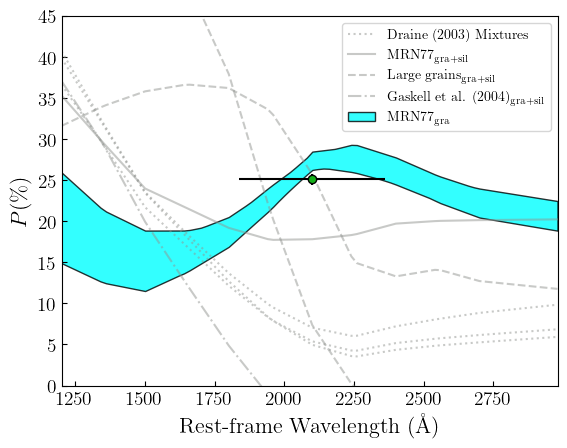

In [31]:
fig, ax = plt.subplots(1)#, figsize=(10,4))#, figsize=(10,4))
plt.subplots_adjust(wspace=0., hspace=0.)

ax.tick_params(axis='both', which='both', direction='in', labelsize=14)

lam_grid = np.arange(1200., 3000., 20.)*u.AA
ax.set_xlim([np.min(lam_grid.value), np.max(lam_grid.value)])

for mm, osk in enumerate(other_sk):
    oskm = other_sk_models[mm]
    kk = np.argmin(other_chi2[mm])
    ax.plot(lam_grid, 100*osk.p((iang_grid[kk]*np.ones(lam_grid.shape), lam_grid)), c='xkcd:grey',ls=oskm["ls"], label=oskm["label"], alpha=0.5)

min_curve = np.zeros(len(lam_grid)) + 1e32
max_curve = np.zeros(len(lam_grid))
for ind in np.argwhere(chi2_map[wid]<1.0):
    i1, j1, k1 = ind
    curve = 100*pw.p((tang_grid[i1]*np.ones(lam_grid.shape), cang_grid[j1]*np.ones(lam_grid.shape), iang_grid[k1]*np.ones(lam_grid.shape), lam_grid))
    min_curve = np.where(curve<min_curve, curve, min_curve)
    max_curve = np.where(curve>max_curve, curve, max_curve)
#ax.fill_between(lam_grid.value, min_curve, max_curve, color='xkcd:green', alpha=0.5, label=r'$\rm MRN77_{\rm gra}$')
ax.fill_between(lam_grid.value, min_curve, max_curve, color='cyan', alpha=0.8, label=r'$\rm MRN77_{\rm gra}$', ec='black')
#ax.plot(lam_grid.value, min_curve, 'k-', alpha=0.7)
#ax.plot(lam_grid.value, max_curve, 'k-', alpha=0.7)


for bname in op.pfrac[wid].keys():

    ax.errorbar([bands.bp[bname].barlam().value/(1+op.z[wid])], [op.pfrac[wid][bname]], xerr=[bands.bp[bname].rectwidth().value/2./(1+op.z[wid])], yerr=[op.epfrac[wid][bname]], marker='o', c='xkcd:green', markeredgecolor='black', ecolor='black')

ax.legend()#loc=(0.67, 0.7))

ax.set_ylim([0., 45.])

ax.set_ylabel(r"$P (\%)$", fontsize=16)
ax.set_xlabel(r"Rest-frame Wavelength $(\rm \AA)$", fontsize=16)

fig.savefig("SKIRTOR_W0204.png", dpi=200, bbox_inches='tight')


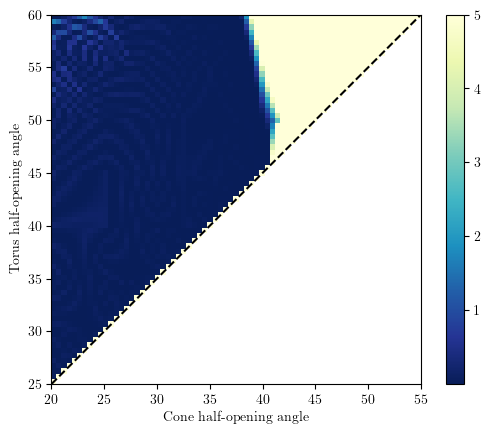

In [14]:
chi2_aux = np.min(chi2_map[wid], axis=2)
for i, tang in enumerate(tang_grid):
    for j, cang in enumerate(cang_grid):
        if cang+5*u.deg > tang:
            chi2_aux[i,j] = np.nan
cmap = 'YlGnBu_r'
#cmap = 'gray'
cb = plt.imshow(chi2_aux, origin='lower', vmax=5., cmap=cmap, extent=[np.min(cang_grid.value), np.max(cang_grid.value), np.min(tang_grid.value), np.max(tang_grid.value)])
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
plt.plot(plt.xlim(), np.array(plt.xlim())+5, 'k--') 
plt.xlabel("Cone half-opening angle")
plt.ylabel("Torus half-opening angle")
plt.colorbar(cb)

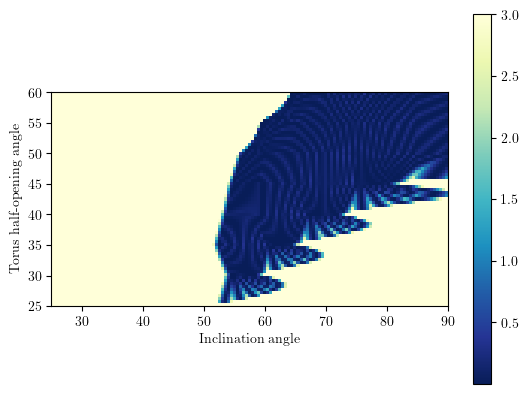

In [15]:
cb = plt.imshow(np.min(chi2_map[wid], axis=1), origin='lower', vmax=3., cmap='YlGnBu_r', extent=[np.min(iang_grid.value), np.max(iang_grid.value), np.min(tang_grid.value), np.max(tang_grid.value)])
plt.xlabel("Inclination angle")
plt.ylabel("Torus half-opening angle")
plt.colorbar(cb)

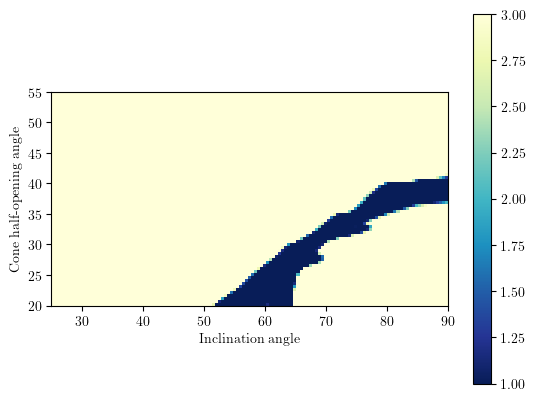

In [16]:
cb = plt.imshow(np.min(chi2_map[wid], axis=0), origin='lower', vmin=1.0, vmax=3., cmap='YlGnBu_r', extent=[np.min(iang_grid.value), np.max(iang_grid.value), np.min(cang_grid.value), np.max(cang_grid.value)])
plt.xlabel("Inclination angle")
plt.ylabel("Cone half-opening angle")
plt.colorbar(cb)

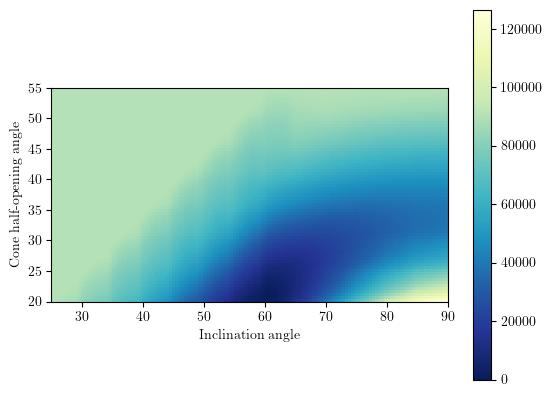

In [17]:
chi2_use = np.sum(chi2_map[wid], axis=0)
chi2_use -= np.min(chi2_use)
cb = plt.imshow(chi2_use, origin='lower', cmap='YlGnBu_r', extent=[np.min(iang_grid.value), np.max(iang_grid.value), np.min(cang_grid.value), np.max(cang_grid.value)])
plt.xlabel("Inclination angle")
plt.ylabel("Cone half-opening angle")
plt.colorbar(cb)

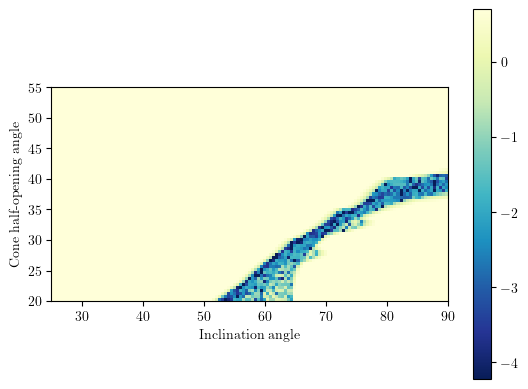

In [18]:
cb = plt.imshow(np.log10(np.min(chi2_map[wid], axis=0)), origin='lower', vmin=np.log10(6e-5), vmax=np.log10(5.), cmap='YlGnBu_r', extent=[np.min(iang_grid.value), np.max(iang_grid.value), np.min(cang_grid.value), np.max(cang_grid.value)])
plt.xlabel("Inclination angle")
plt.ylabel("Cone half-opening angle")
plt.colorbar(cb)

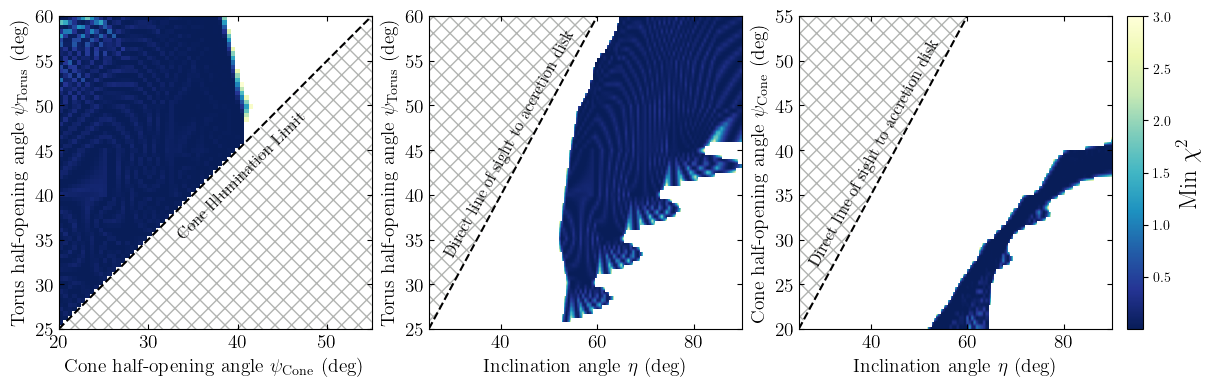

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(12,6), layout='constrained')
for ax in axs.flatten():
   #ax.tick_params(axis='both', which='major', labelsize=14)
   #ax.tick_params(axis='both', which='minor', labelsize=12)
   ax.tick_params(axis='both', direction='in', labelsize=14, bottom=True, top=True, left=True, right=True)
#    ax.set_aspect('auto')

vmin = np.min(chi2_map[wid])
vmax = 3.0
cmap = 'YlGnBu_r'
#cmap = 'gray'

axis_label_fontsize = 14

chi2_use = np.ma.zeros(chi2_map[wid].shape)
chi2_use.mask = np.zeros(chi2_use.shape, dtype=bool)
chi2_use[:,:,:] = np.copy(chi2_map[wid])
II, JJ, KK = np.meshgrid(tang_grid.value, cang_grid.value, iang_grid.value, indexing='ij')
chi2_use.mask[(JJ+5>II) | (KK<II)] = True
#chi2_use.mask[(JJ+10>II) | (II>KK)] = True
#chi2_use.mask[(JJ+15>II) | (II>KK)] = True
chi2_use.mask[chi2_use>vmax] = True

#Torus - Cone
ax = axs[0]
chi2_aux = np.min(chi2_use, axis=2)
cb = ax.imshow(chi2_aux, origin='lower', vmin=vmin, vmax=vmax, cmap=cmap, extent=[np.min(cang_grid.value), np.max(cang_grid.value), np.min(tang_grid.value), np.max(tang_grid.value)])
ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_ylim())
ax.plot(ax.get_xlim(), np.array(ax.get_xlim())+5, 'k--') 
ax.fill_between(ax.get_xlim(), np.array(ax.get_xlim())+5, ax.get_ylim()[0], color="none", hatch="xx", edgecolor="xkcd:gray", linewidth=0.0, alpha=0.7)
ax.set_xlabel(r"Cone half-opening angle $\psi_{\rm Cone}$ (deg)", fontsize=axis_label_fontsize)
ax.set_ylabel(r"Torus half-opening angle $\psi_{\rm Torus}$ (deg)", fontsize=axis_label_fontsize)
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))
ax.text(33, 35, "Cone Illumination Limit", rotation=np.arctan2(abs(x1-x0), abs(y1-y0))*180/np.pi, fontsize=12, weight='extra bold', fontfamily='sans-serif')

#Torus - Inclination
ax = axs[1]
chi2_aux = np.min(chi2_use, axis=1)
ax.imshow(chi2_aux, origin='lower', vmin=vmin, vmax=vmax, cmap=cmap, extent=[np.min(iang_grid.value), np.max(iang_grid.value), np.min(tang_grid.value), np.max(tang_grid.value)])
ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_ylim())
ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--') 
ax.fill_between(ax.get_xlim(), np.array(ax.get_xlim()), ax.get_ylim()[1], color="none", hatch="xx", edgecolor="xkcd:gray", linewidth=0.0, alpha=0.7)
ax.set_xlabel(r"Inclination angle $\eta$ (deg)", fontsize=axis_label_fontsize)
ax.set_ylabel(r"Torus half-opening angle $\psi_{\rm Torus}$ (deg)", fontsize=axis_label_fontsize)
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))
ax.text(28, 33, "Direct line of sight to accretion disk", rotation=np.arctan2(abs(x1-x0), abs(y1-y0))*180/np.pi, fontsize=12, weight='extra bold', fontfamily='sans-serif')

#Cone - Inclination
ax = axs[2]
chi2_aux = np.min(chi2_use, axis=0)
cb = plt.imshow(chi2_aux, origin='lower', vmin=vmin, vmax=vmax, cmap=cmap, extent=[np.min(iang_grid.value), np.max(iang_grid.value), np.min(cang_grid.value), np.max(cang_grid.value)])
ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_ylim())
ax.plot(ax.get_xlim(), np.array(ax.get_xlim())-5, 'k--') 
ax.fill_between(ax.get_xlim(), np.array(ax.get_xlim())-5, ax.get_ylim()[1], color="none", hatch="xx", edgecolor="xkcd:gray", linewidth=0.0, alpha=0.7)
plt.xlabel(r"Inclination angle $\eta$ (deg)", fontsize=axis_label_fontsize)
plt.ylabel(r"Cone half-opening angle $\psi_{\rm Cone}$ (deg)", fontsize=axis_label_fontsize)
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))
ax.text(27, 27, "Direct line of sight to accretion disk", rotation=np.arctan2(abs(x1-x0), abs(y1-y0))*180/np.pi, fontsize=12, weight='extra bold', fontfamily='sans-serif')

fig.colorbar(cb, fraction=0.05).set_label(label=r'Min $\chi^2$',size=18)

plt.show()
fig.savefig("W0204_chi2maps.png", dpi=200, bbox_inches='tight')

In [20]:
#Gas mass estimate for the best-fit cone with the MRN77 dust. 
i, j, k = np.unravel_index(np.argmin(chi2_map[wid], axis=None), chi2_map[wid].shape)
print(tang_grid[i], cang_grid[j], iang_grid[k], chi2_map[wid].min())

tau_V = 0.1
delta_psi_c = 10*u.deg #10*u.deg
psi_c = np.array([10, 38, 40])*u.deg #cang_grid[j]
X = 1.5e-23*u.cm**2
L = 10*u.kpc
Rv = 3.1

Mg = (2.5/np.log(10.)) * np.pi/3. * m_p * tau_V/(X*Rv) * L**2 * np.cos(psi_c-delta_psi_c/2.)*(np.tan(psi_c))**2
print((Mg/M_sun).to(u.dimensionless_unscaled)/1e9)

#Now the obscuration of a light ray going through the dusty section of the cone at mid-height
d = 0.5*L*(np.tan(psi_c)-np.tan(psi_c-delta_psi_c))
n_H = (2.5/np.log(10.)) * tau_V/(X*Rv) * np.cos(psi_c-delta_psi_c/2.)/L
print(d, n_H.to(u.cm**-3), X*n_H*d)


48.0 deg 35.5 deg 75.5 deg 1.0702936615588873e-07
[0.06065613 1.00254534 1.12949556]
[0.8816349  1.24788097 1.30874681] kpc [0.07538155 0.06346178 0.06198482] 1 / cm3 [0.00307607 0.00366545 0.00375477]


In [21]:
m_p.__dict__

{'_abbrev': 'm_p',
 '_name': 'Proton mass',
 '_value': 1.67262192369e-27,
 '_unit_string': 'kg',
 '_uncertainty': 5.1e-37,
 '_reference': 'CODATA 2018',
 '_system': None,
 '_checked_units': True,
 '_unit': Unit("kg")}

In [22]:
616. / np.cos(60*u.deg), 616. / np.cos(80*u.deg)

(<Quantity 1232.>, <Quantity 3547.40261762>)